# AWS -  API Analysis & Validation  
**Phase 1 – Week 1**

This notebook validates:
- Python environment setup
- AWS Bedrock API connectivity
- CloudWatch metrics access
- AWS Cost Explorer access

The goal is to confirm authentication, permissions, and data availability
as a foundation for multi-cloud governance and FinOps analysis.

## 1. Environment Setup & Dependencies

This section initializes the Python environment, loads environment variables,
and imports required SDKs for AWS Services.

Credentials are loaded securely using environment variables.


In [14]:
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta, timezone
import boto3
import matplotlib.pyplot as plt
import pandas as pd
load_dotenv()

True

## 2. Bedrock API Validation – Model Discovery

We validate AWS Bedrock API access by discovering available foundation models.
Successful execution confirms:
- AWS authentication is configured correctly
- Bedrock permissions are in place
- SDK integration is functional


In [5]:
bedrock = boto3.client(service_name="bedrock")

response = bedrock.list_foundation_models()
models = response.get("modelSummaries", [])

# Normalize into rows
rows = []
for model in models:
    rows.append({
        "model_id": model.get("modelId"),
        "provider": model.get("providerName"),
        "input_modalities": ", ".join(model.get("inputModalities", [])),
        "output_modalities": ", ".join(model.get("outputModalities", [])),
    })

df = pd.DataFrame(rows)

df.head(15)

,model_id,provider,input_modalities,output_modalities
0,google.gemma-3-4b-it,Google,"TEXT, IMAGE",TEXT
1,nvidia.nemotron-nano-12b-v2,NVIDIA,"TEXT, IMAGE",TEXT
2,anthropic.claude-haiku-4-5-20251001-v1:0,Anthropic,"TEXT, IMAGE",TEXT
3,qwen.qwen3-235b-a22b-2507-v1:0,Qwen,TEXT,TEXT
4,openai.gpt-oss-safeguard-120b,OpenAI,TEXT,TEXT
5,google.gemma-3-27b-it,Google,"TEXT, IMAGE",TEXT
6,openai.gpt-oss-120b-1:0,OpenAI,TEXT,TEXT
7,anthropic.claude-sonnet-4-5-20250929-v1:0,Anthropic,"TEXT, IMAGE",TEXT
8,qwen.qwen3-vl-235b-a22b,Qwen,"TEXT, IMAGE",TEXT
9,qwen.qwen3-next-80b-a3b,Qwen,TEXT,TEXT


## 3. CloudWatch API Validation – Bedrock Metrics Discovery

This section queries CloudWatch for metrics under the AWS/Bedrock namespace.
The goal is to validate observability access.
Metric discovery confirms:
- CloudWatch API connectivity
- Monitoring permissions
- Availability of Bedrock operational metrics


In [6]:
cloudwatch = boto3.client("cloudwatch", region_name="us-east-1")

response = cloudwatch.list_metrics(
    Namespace="AWS/Bedrock"
)

metrics = response.get("Metrics", [])

df_metrics = pd.DataFrame([
    {
        "MetricName": m["MetricName"],
        "Dimensions": m.get("Dimensions", [])
    }
    for m in metrics
])

df_metrics.head(10)

,MetricName,Dimensions
0,InvocationClientErrors,"[{'Name': 'ModelId', 'Value': 'anthropic.claud..."
1,Invocations,"[{'Name': 'ModelId', 'Value': 'anthropic.claud..."
2,Invocations,"[{'Name': 'ModelId', 'Value': 'meta.llama3-8b-..."
3,OutputTokenCount,"[{'Name': 'ModelId', 'Value': 'meta.llama3-8b-..."
4,InputTokenCount,"[{'Name': 'ModelId', 'Value': 'meta.llama3-8b-..."
5,InvocationLatency,"[{'Name': 'ModelId', 'Value': 'meta.llama3-8b-..."
6,OutputTokenCount,"[{'Name': 'ModelId', 'Value': 'us.anthropic.cl..."
7,InputTokenCount,"[{'Name': 'ModelId', 'Value': 'us.anthropic.cl..."
8,Invocations,"[{'Name': 'ModelId', 'Value': 'us.anthropic.cl..."
9,InvocationLatency,"[{'Name': 'ModelId', 'Value': 'us.anthropic.cl..."


In [ ]:
# Expand ModelId from Dimensions
rows = []
for m in metrics:
    model_id = None
    for d in m.get("Dimensions", []):
        if d["Name"] == "ModelId":
            model_id = d["Value"]

    rows.append({
        "MetricName": m["MetricName"],
        "ModelId": model_id
    })

df_clean = pd.DataFrame(rows)
df_clean.head()


,MetricName,ModelId
0,InvocationClientErrors,anthropic.claude-3-haiku-20240307-v1:0
1,Invocations,anthropic.claude-3-haiku-20240307-v1:0
2,Invocations,meta.llama3-8b-instruct-v1:0
3,OutputTokenCount,meta.llama3-8b-instruct-v1:0
4,InputTokenCount,meta.llama3-8b-instruct-v1:0


In [10]:
df_summary = (
    df_clean
    .groupby(["ModelId", "MetricName"])
    .size()
    .reset_index(name="count")
)

df_summary.head()


,ModelId,MetricName,count
0,anthropic.claude-3-haiku-20240307-v1:0,InvocationClientErrors,1
1,anthropic.claude-3-haiku-20240307-v1:0,Invocations,1
2,meta.llama3-70b-instruct-v1:0,InputTokenCount,1
3,meta.llama3-70b-instruct-v1:0,InvocationLatency,1
4,meta.llama3-70b-instruct-v1:0,Invocations,1


In [11]:
pivot_df = df_summary.pivot(
    index="ModelId",
    columns="MetricName",
    values="count"
).fillna(0)

pivot_df


MetricName,InputTokenCount,InvocationClientErrors,InvocationLatency,Invocations,OutputTokenCount
ModelId,,,,,
anthropic.claude-3-haiku-20240307-v1:0,0.0,1.0,0.0,1.0,0.0
meta.llama3-70b-instruct-v1:0,1.0,0.0,1.0,1.0,1.0
meta.llama3-8b-instruct-v1:0,1.0,0.0,1.0,1.0,1.0
mistral.mistral-large-2402-v1:0,1.0,0.0,1.0,1.0,1.0
mistral.mistral-large-3-675b-instruct,1.0,0.0,1.0,1.0,1.0
us.anthropic.claude-3-5-haiku-20241022-v1:0,1.0,0.0,1.0,1.0,1.0


<Axes: title={'center': 'Bedrock Token Metrics Available per Model'}, xlabel='ModelId'>

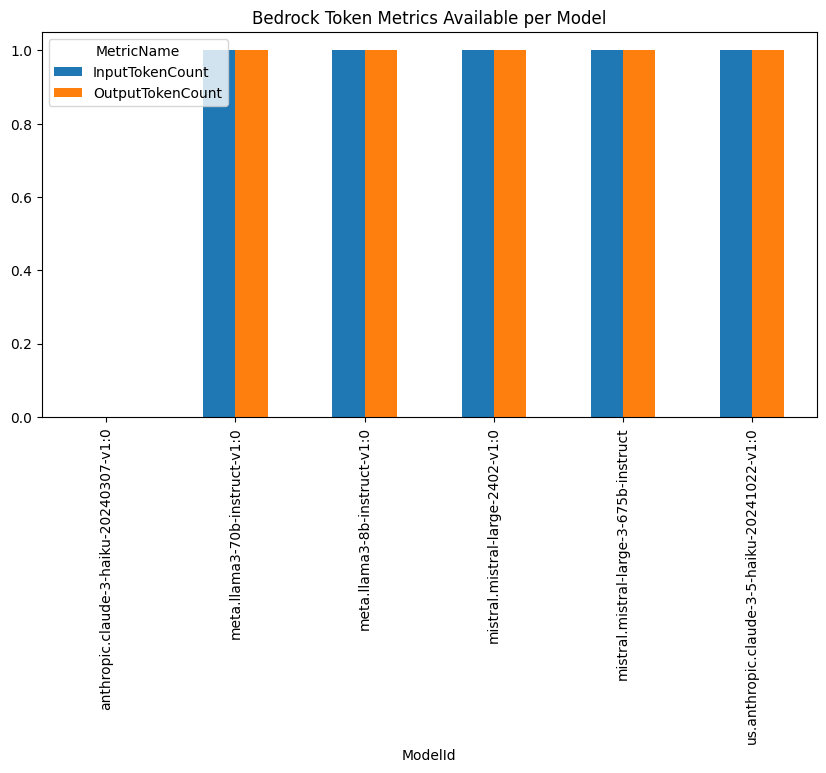

In [15]:
pivot_df[["InputTokenCount", "OutputTokenCount"]].plot(
    kind="bar",
    figsize=(10, 5),
    title="Bedrock Token Metrics Available per Model"
)


## 4. Cost Explorer API Validation – Service-Level Cost Analysis

This section validates AWS Cost Explorer access by retrieving
monthly unblended costs grouped by service.

The output confirms:
- Cost Explorer API access
- Availability of Bedrock-related cost data
- Foundation for FinOps and cost attribution workflows


In [16]:
ce = boto3.client("ce", region_name="us-east-1")

response = ce.get_cost_and_usage(
    TimePeriod={
        "Start": "2026-01-01",
        "End": "2026-02-01"
    },
    Granularity="MONTHLY",
    Metrics=["UnblendedCost"],
    GroupBy=[
        {
            "Type": "DIMENSION",
            "Key": "SERVICE"
        }
    ]
)

rows = []
for group in response["ResultsByTime"][0]["Groups"]:
    rows.append({
        "service": group["Keys"][0],
        "cost_usd": float(group["Metrics"]["UnblendedCost"]["Amount"])
    })

df_cost = pd.DataFrame(rows).sort_values("cost_usd", ascending=False)
df_cost

,service,cost_usd
0,AWS Cost Explorer,1.400000e-01
6,Amazon Bedrock,1.299321e-01
12,Tax,5.000000e-02
10,Amazon Simple Storage Service,3.050000e-08
1,AWS Glue,0.000000e+00
4,AWS Secrets Manager,0.000000e+00
3,AWS Lambda,0.000000e+00
2,AWS Key Management Service,0.000000e+00
5,Amazon API Gateway,0.000000e+00
8,Amazon Simple Notification Service,0.000000e+00


## Summary

This notebook successfully validates:
- Python environment reproducibility
- AWS Bedrock API access
- CloudWatch metrics access
- Cost Explorer cost data access

These validations form the foundation for upcoming phases.
